In [1]:
%%bash
cat > steer_llm.py << 'EOF'
#!/usr/bin/env python3
"""
Enhanced Script for Steering LLM Behavior (e.g., Epistemic Stance, Stylistic Features)
using Activation Vector Manipulation in models like LLaMA-3-8B-Instruct.

Targeted for Research Publication - Incorporates learnings from iterative experiments.

Features:
- CLI with subcommands: compute-vector, steer, evaluate-perplexity, evaluate-style
- Flexible text pair input (JSON) for concept vector computation.
- Concept vector derived using a Linear Probe (Logistic Regression) on MLP activations.
- Options for token aggregation strategy (mean_all_tokens, last_token) for probe training.
- Optional normalization for the computed concept vector.
- Support for multi-layer MLP steering with specified strengths.
- Optional Activation Clipping during steering for fluency control.
- Perplexity evaluation (uses external model like GPT-2 for less bias).
- Style evaluation (Flesch Reading Ease, Flesch-Kincaid Grade, Avg Sentence Length) using textstat.
- Save/load concept vectors (dictionary mapping layer_index to vector).
- Comprehensive logging and CLI arguments for reproducibility.
"""
import os
import sys
import argparse
import json
import logging
import torch
import numpy as np
from torch.nn.functional import normalize as torch_normalize
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    set_seed
)
# from datasets import load_dataset # Not directly used by script, but good for notebook
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from huggingface_hub import login

# Attempt to import textstat, provide message if not found
try:
    import textstat
except ImportError:
    print("textstat library not found. Please install it using 'pip install textstat' to use the evaluate-style command.")
    textstat = None


# ----- Logging Configuration -----
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(module)s:%(lineno)d %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger(__name__)

# Optional HF authentication
HF_TOKEN = os.environ.get('HF_TOKEN')
if HF_TOKEN:
    login(token=HF_TOKEN)

# Strip Jupyter args
orig_args = sys.argv[:]
clean_args = [orig_args[0]]
skip_next = False
for a in orig_args[1:]:
    if skip_next:
        skip_next = False
        continue
    if a == '-f':
        skip_next = True
        continue
    b = os.path.basename(a)
    if b.startswith('kernel-') and b.endswith('.json'):
        continue
    clean_args.append(a)
sys.argv = clean_args

# ----- Utility Functions -----
def load_model_and_tokenizer(model_name: str, device: str = 'cuda', dtype_str: str = 'bfloat16'):
    logger.info(f"Loading model {model_name} on {device} (dtype={dtype_str})")
    if dtype_str == 'bfloat16':
        dtype = torch.bfloat16
    elif dtype_str == 'float16':
        dtype = torch.float16
    else:
        dtype = torch.float32

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=HF_TOKEN)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token or tokenizer.pad_token_id
    tokenizer.padding_side = 'left' # Important for batch generation

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=dtype,
        device_map='auto',
        use_auth_token=HF_TOKEN
    )
    model.eval()
    return model, tokenizer

class ActivationExtractor:
    def __init__(self, model, mlp_layer_indices, extraction_type='mlp'):
        self.model = model
        self.layer_indices = mlp_layer_indices # Should be actual, non-negative indices
        self.extraction_type = extraction_type
        self.handles = []
        self.activations = {idx: [] for idx in mlp_layer_indices}

    def _make_hook(self, layer_target_idx):
        def hook(module, inp, outp):
            activation_to_store = outp[0] if isinstance(outp, tuple) and self.extraction_type == 'full_layer' else outp
            self.activations[layer_target_idx].append(activation_to_store.detach().cpu())
        return hook

    def register(self):
        self.unregister()
        self.activations = {idx: [] for idx in self.layer_indices}
        for actual_idx in self.layer_indices: # Assumes layer_indices are already actual
            if self.extraction_type == 'mlp':
                module = self.model.model.layers[actual_idx].mlp
            elif self.extraction_type == 'full_layer':
                module = self.model.model.layers[actual_idx]
            else:
                raise ValueError(f"Unknown extraction_type: {self.extraction_type}")
            handle = module.register_forward_hook(self._make_hook(actual_idx))
            self.handles.append(handle)
        # Removed verbose logging from here to reduce console spam during batch processing

    def unregister(self):
        for h in self.handles:
            h.remove()
        self.handles = []

# ----- Core Functionality -----
def compute_concept_vector_with_probe(
    model, tokenizer,
    positive_texts, negative_texts,
    user_layer_indices, batch_size: int, # user_layer_indices can be relative
    aggregation_strategy: str, normalize_vector: bool,
    seed: int, device: str, max_length: int,
    extraction_type: str = 'mlp'
):
    set_seed(seed)
    actual_layer_indices = [idx if idx >= 0 else len(model.model.layers) + idx for idx in user_layer_indices]
    logger.info(f"Targeting {'MLP' if extraction_type == 'mlp' else 'Full Decoder'} layers (user-specified: {user_layer_indices}, actual: {actual_layer_indices}) for vC computation.")
    extractor = ActivationExtractor(model, actual_layer_indices, extraction_type=extraction_type)

    def collect_activations(texts, label):
        for idx in actual_layer_indices: extractor.activations[idx] = [] # Reset for this call
        all_acts_for_texts = {idx: [] for idx in actual_layer_indices}

        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
            extractor.register()
            with torch.no_grad(): model(**inputs)
            extractor.unregister()

            for idx_loop in actual_layer_indices:
                if not extractor.activations[idx_loop]:
                    logger.warning(f"No activations for layer {idx_loop}, batch {i//batch_size}, {label} texts.")
                    continue
                feats_batch_layer = torch.cat(extractor.activations[idx_loop], dim=0)
                extractor.activations[idx_loop] = [] # Clear after use for this batch

                if aggregation_strategy == 'mean_all_tokens':
                    mask = inputs.attention_mask.unsqueeze(-1).expand_as(feats_batch_layer).float().cpu()
                    masked_activations = feats_batch_layer * mask
                    summed_activations = masked_activations.sum(dim=1)
                    num_tokens = mask.sum(dim=1); num_tokens = torch.clamp(num_tokens, min=1e-9)
                    aggregated_feats = summed_activations / num_tokens
                elif aggregation_strategy == 'last_token':
                    lengths = inputs.attention_mask.sum(dim=1)
                    aggregated_feats = torch.stack([feats_batch_layer[k, lengths[k]-1] for k in range(feats_batch_layer.size(0))])
                else: raise ValueError(f"Unknown aggregation: {aggregation_strategy}")
                all_acts_for_texts[idx_loop].append(aggregated_feats)

        final_acts = {idx: torch.cat(all_acts_for_texts[idx], dim=0) if all_acts_for_texts[idx] else torch.empty(0, model.config.hidden_size, device='cpu')
                      for idx in actual_layer_indices}
        return final_acts

    pos_acts = collect_activations(positive_texts, 'positive')
    neg_acts = collect_activations(negative_texts, 'negative')

    concept_vectors = {}
    for idx in actual_layer_indices:
        if not pos_acts[idx].numel() or not neg_acts[idx].numel():
            logger.warning(f"Skipping layer {idx}: no pos/neg activations.")
            continue
        X_pos, X_neg = pos_acts[idx].numpy(), neg_acts[idx].numpy()
        if X_pos.shape[0] == 0 or X_neg.shape[0] == 0 or (X_pos.shape[0] + X_neg.shape[0] < 2) :
            logger.warning(f"Skipping layer {idx}: insufficient samples after processing.")
            continue
        y = np.array([1]*X_pos.shape[0] + [0]*X_neg.shape[0]); X = np.vstack([X_pos, X_neg])
        scaler = StandardScaler(); X_scaled = scaler.fit_transform(X)
        probe = LogisticRegression(solver='liblinear', C=1.0, class_weight='balanced', random_state=seed)
        try:
            probe.fit(X_scaled, y)
        except ValueError as e:
            logger.error(f"Error fitting probe for layer {idx}: {e}. Check class balance and data variance.")
            continue

        coef = probe.coef_[0]
        vec = torch_normalize(torch.tensor(coef, dtype=torch.float32).unsqueeze(0), dim=1).squeeze(0) if normalize_vector else torch.tensor(coef, dtype=torch.float32)
        concept_vectors[idx] = vec.to(device)
        logger.info(f"Computed vC for layer {idx}, norm={vec.norm():.3f}, shape={vec.shape}")
    return concept_vectors

def steer_generation_with_mlp_intervention(
    model, tokenizer, prompt: str,
    concept_vectors: dict, strengths: dict, # strengths keys should be string of actual layer_idx
    max_new_tokens: int, temperature: float, do_sample: bool,
    clip_min: float, clip_max: float, device: str, seed: int,
    extraction_type_steering: str = 'mlp'
):
    set_seed(seed)
    handles = []
    active_steering_info = []
    num_model_layers = len(model.model.layers)

    for layer_key_str, strength_val in strengths.items():
        try: layer_idx_steer_user = int(layer_key_str)
        except ValueError: logger.warning(f"Invalid layer key '{layer_key_str}'. Skipping."); continue

        actual_layer_idx_steer = layer_idx_steer_user if layer_idx_steer_user >= 0 else num_model_layers + layer_idx_steer_user
        if not (0 <= actual_layer_idx_steer < num_model_layers):
            logger.warning(f"Actual layer index {actual_layer_idx_steer} (from {layer_key_str}) out of bounds. Skipping."); continue

        concept_vec_to_apply = concept_vectors.get(actual_layer_idx_steer)
        if concept_vec_to_apply is None or strength_val == 0:
            if strength_val !=0 and concept_vec_to_apply is None:
                 logger.warning(f"Strength {strength_val} for layer {actual_layer_idx_steer} but no vector found in file.")
            continue

        def hook_fn_closure(cv, strength_hook, use_clip, c_min, c_max, current_extraction_type):
            def actual_hook(module, inp, outp_main):
                original_activation = outp_main[0] if isinstance(outp_main, tuple) and current_extraction_type == 'full_layer' else outp_main
                modified_activation = original_activation.clone()
                cv_device_dtype = cv.to(modified_activation.device, dtype=modified_activation.dtype)
                modified_activation += (strength_hook * cv_device_dtype.unsqueeze(0).unsqueeze(0))
                if use_clip and c_min is not None and c_max is not None:
                    modified_activation = torch.clamp(modified_activation, c_min, c_max)
                return (modified_activation,) + outp_main[1:] if isinstance(outp_main, tuple) and current_extraction_type == 'full_layer' else modified_activation
            return actual_hook

        module_to_hook = model.model.layers[actual_layer_idx_steer].mlp if extraction_type_steering == 'mlp' else model.model.layers[actual_layer_idx_steer]

        current_clip_active = clip_min is not None and clip_max is not None
        handles.append(module_to_hook.register_forward_hook(
            hook_fn_closure(concept_vec_to_apply, strength_val, current_clip_active, clip_min, clip_max, extraction_type_steering)
        ))
        active_steering_info.append(f"L{actual_layer_idx_steer}({extraction_type_steering}) alpha={strength_val} Clip={'ON' if current_clip_active else 'OFF'}")

    if active_steering_info: logger.info(f"Steering active: {'; '.join(active_steering_info)}")
    else: logger.info("No effective steering applied (baseline or no valid strengths/vectors).")

    gen_cfg = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=do_sample, temperature=temperature if do_sample else None, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)

    # ** FIX FOR OverflowError **
    # Cap tokenizer.model_max_length if it's excessively large
    effective_tokenizer_max_len = tokenizer.model_max_length
    practical_model_limit = 8192 # Llama 3 8B context window
    if effective_tokenizer_max_len is None or effective_tokenizer_max_len > practical_model_limit * 2 : # Heuristic for "too large"
        logger.warning(f"tokenizer.model_max_length ({tokenizer.model_max_length}) is very large or None. Using practical limit {practical_model_limit}.")
        effective_tokenizer_max_len = practical_model_limit

    input_max_len = effective_tokenizer_max_len - max_new_tokens - 5 # Buffer for special tokens, etc.
    if input_max_len <= 0:
        logger.warning(f"Calculated input_max_len ({input_max_len}) is non-positive. Setting to a small default (e.g., 64). Check prompt length and max_new_tokens.")
        input_max_len = 64 # Fallback to a small positive number

    logger.info(f"Tokenizing prompt with max_length={input_max_len} (derived from effective_tokenizer_max_len={effective_tokenizer_max_len}, max_new_tokens={max_new_tokens})")
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True, max_length=input_max_len).to(device)

    with torch.no_grad(): outputs = model.generate(**inputs, generation_config=gen_cfg)
    for h in handles: h.remove()
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def evaluate_perplexity_external(texts, ppl_model_name: str, device: str, batch_size: int, max_length_ppl: int = 1024):
    from transformers import AutoModelForCausalLM as PPLModel, AutoTokenizer as PPLTokenizer
    logger.info(f"Loading PPL model: {ppl_model_name}")
    tok = PPLTokenizer.from_pretrained(ppl_model_name)
    mod = PPLModel.from_pretrained(ppl_model_name).to(device)
    mod.eval()
    if tok.pad_token is None: tok.pad_token = tok.eos_token
    total_nll, total_tokens, num_valid_texts = 0.0, 0, 0
    for i in range(0, len(texts), batch_size):
        batch_texts = [t for t in texts[i:i+batch_size] if isinstance(t, str) and t.strip() and "ERROR" not in t and "EXCEPTION" not in t] # Filter out error strings
        if not batch_texts: continue
        num_valid_texts += len(batch_texts)
        enc = tok(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length_ppl).to(device)
        if enc.input_ids.numel() == 0: continue
        with torch.no_grad(): out = mod(enc.input_ids, labels=enc.input_ids)
        num_loss_tokens = (enc.input_ids != tok.pad_token_id).sum().item()
        if num_loss_tokens > 0:
            total_nll += out.loss.item() * num_loss_tokens
            total_tokens += num_loss_tokens
    if total_tokens == 0 or num_valid_texts == 0:
        logger.warning("No valid texts/tokens for PPL."); return float('inf')
    avg_nll = total_nll / total_tokens
    ppl = torch.exp(torch.tensor(avg_nll)).item()
    logger.info(f"Perplexity (over {num_valid_texts} texts, {total_tokens} tokens): {ppl:.4f}")
    return ppl

def evaluate_style_metrics(texts, output_metrics_file: str):
    if textstat is None:
        logger.error("textstat not installed."); metrics = {"error": "textstat not installed"}
        with open(output_metrics_file, 'w') as f: json.dump(metrics, f); return metrics

    valid_texts_for_style = [t for t in texts if isinstance(t, str) and t.strip() and "ERROR" not in t and "EXCEPTION" not in t] # Filter out error strings
    if not valid_texts_for_style:
        logger.warning("No valid texts provided for style evaluation after filtering.")
        metrics = {"flesch_reading_ease": float('nan'), "flesch_kincaid_grade": float('nan'), "avg_sentence_length": float('nan'), "num_texts": 0}
        with open(output_metrics_file, 'w') as f: json.dump(metrics, f); return metrics

    f_ease, fk_grade, asl_scores = [], [], []
    for text in valid_texts_for_style:
        try:
            f_ease.append(textstat.flesch_reading_ease(text))
            fk_grade.append(textstat.flesch_kincaid_grade(text))
            s_count = textstat.sentence_count(text); w_count = textstat.lexicon_count(text, True)
            asl_scores.append(w_count / s_count if s_count > 0 else (w_count if w_count > 0 else 0))
        except Exception as e:
            logger.warning(f"Style metric error for text: '{text[:30]}...': {e}")
            f_ease.append(float('nan')); fk_grade.append(float('nan')); asl_scores.append(float('nan'))

    num_evaluated = len(valid_texts_for_style)
    metrics = {
        "flesch_reading_ease": np.nanmean(f_ease) if f_ease else float('nan'),
        "flesch_kincaid_grade": np.nanmean(fk_grade) if fk_grade else float('nan'),
        "avg_sentence_length": np.nanmean(asl_scores) if asl_scores else float('nan'),
        "num_texts": num_evaluated
    }
    logger.info(f"Style Metrics ({num_evaluated} texts): FRE={metrics['flesch_reading_ease']:.2f}, FKG={metrics['flesch_kincaid_grade']:.2f}, ASL={metrics['avg_sentence_length']:.2f}")
    with open(output_metrics_file, 'w') as f: json.dump(metrics, f, indent=2)
    return metrics

def main():
    parser = argparse.ArgumentParser(description="LLM Concept Steering CLI")
    parser.add_argument('--model_name',type=str,default="meta-llama/Meta-Llama-3-8B-Instruct")
    parser.add_argument('--dtype',type=str,default='bfloat16',choices=['bfloat16','float16','float32'])
    parser.add_argument('--seed',type=int,default=42)

    sub = parser.add_subparsers(dest='cmd', required=True)

    cvp = sub.add_parser('compute-vector')
    cvp.add_argument('--positive_texts_json', required=True)
    cvp.add_argument('--negative_texts_json', required=True)
    cvp.add_argument('--mlp_layer_indices', nargs='+', type=int, default=[-1])
    cvp.add_argument('--extraction_type', choices=['mlp', 'full_layer'], default='mlp')
    cvp.add_argument('--batch_size', type=int, default=8)
    cvp.add_argument('--aggregation_strategy', choices=['mean_all_tokens','last_token'], default='mean_all_tokens')
    cvp.add_argument('--normalize_vector', action='store_true')
    cvp.add_argument('--max_length', type=int, default=192)
    cvp.add_argument('--output_vector_file', required=True)

    stp = sub.add_parser('steer')
    stp.add_argument('--prompt', required=True)
    stp.add_argument('--concept_vector_file', required=True)
    stp.add_argument('--strengths_json', required=True)
    stp.add_argument('--steering_extraction_type', choices=['mlp', 'full_layer'], default='mlp')
    stp.add_argument('--max_new_tokens', type=int, default=60)
    stp.add_argument('--temperature', type=float, default=0.7)
    stp.add_argument('--do_sample', action='store_true', default=True)
    stp.add_argument('--clip_min', type=float)
    stp.add_argument('--clip_max', type=float)

    evp_ppl = sub.add_parser('evaluate-perplexity')
    evp_ppl.add_argument('--texts_json', required=True)
    evp_ppl.add_argument('--ppl_model_name', default='gpt2')
    evp_ppl.add_argument('--batch_size', type=int, default=4)
    evp_ppl.add_argument('--max_length_ppl', type=int, default=1024)

    evp_style = sub.add_parser('evaluate-style')
    evp_style.add_argument('--texts_json', required=True)
    evp_style.add_argument('--output_metrics_file', required=True)
    evp_style.add_argument('--ppl_model_name', default='gpt2')
    evp_style.add_argument('--batch_size_ppl', type=int, default=4)
    evp_style.add_argument('--max_length_ppl', type=int, default=1024)

    args = parser.parse_args()
    set_seed(args.seed)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if args.cmd=='compute-vector':
        model_compute, tok_compute = load_model_and_tokenizer(args.model_name, device=device, dtype_str=args.dtype)
        with open(args.positive_texts_json, 'r') as f: pos = json.load(f)
        with open(args.negative_texts_json, 'r') as f: neg = json.load(f)
        if not pos or not neg: logger.error("Pos/neg lists empty."); return
        cvs = compute_concept_vector_with_probe(
            model_compute, tok_compute, pos, neg, args.mlp_layer_indices, args.batch_size,
            args.aggregation_strategy, args.normalize_vector, args.seed,
            device, args.max_length, extraction_type=args.extraction_type
        )
        if cvs: torch.save(cvs, args.output_vector_file); logger.info(f"Saved vCs to {args.output_vector_file}")
        else: logger.error("vC computation failed.")

    elif args.cmd=='steer':
        model_steer, tok_steer = load_model_and_tokenizer(args.model_name, device=device, dtype_str=args.dtype)
        cvs_loaded = torch.load(args.concept_vector_file, map_location=device)
        with open(args.strengths_json, 'r') as f: raw_strengths = json.load(f)

        strengths_processed = {}
        num_layers_for_steer = len(model_steer.model.layers)
        for k_str, v_strength in raw_strengths.items():
            try: k_int = int(k_str); actual_k_steer = k_int if k_int >=0 else num_layers_for_steer + k_int
            except ValueError: logger.warning(f"Invalid layer key '{k_str}'. Skipping."); continue
            if 0 <= actual_k_steer < num_layers_for_steer:
                if actual_k_steer in cvs_loaded: strengths_processed[str(actual_k_steer)] = v_strength
                else: logger.warning(f"Strength for layer {k_str} (actual: {actual_k_steer}), but no vector in file. Skipping.")
            else: logger.warning(f"Layer key {k_str} (actual {actual_k_steer}) out of bounds. Skipping.")

        out_text = steer_generation_with_mlp_intervention(
            model_steer, tok_steer, args.prompt, cvs_loaded, strengths_processed,
            args.max_new_tokens, args.temperature, args.do_sample,
            args.clip_min, args.clip_max, device, args.seed,
            extraction_type_steering=args.steering_extraction_type
        )
        print(out_text)

    elif args.cmd=='evaluate-perplexity':
        with open(args.texts_json, 'r') as f: texts = json.load(f)
        if not texts or not any(isinstance(t, str) and t.strip() for t in texts):
            logger.warning("No valid texts for PPL."); print("Perplexity: NaN"); return
        ppl = evaluate_perplexity_external(texts, args.ppl_model_name, device, args.batch_size, args.max_length_ppl)
        print(f"Final Perplexity: {ppl:.4f}")

    elif args.cmd=='evaluate-style':
        if textstat is None: logger.error("textstat not installed.");
        with open(args.texts_json, 'r') as f: texts = json.load(f)
        if not texts or not any(isinstance(t, str) and t.strip() for t in texts):
            logger.warning("No valid texts for style.")
            metrics = {"flesch_reading_ease": float('nan'), "flesch_kincaid_grade": float('nan'), "avg_sentence_length": float('nan'), "perplexity": float('nan'), "num_texts": 0}
        else:
            metrics = evaluate_style_metrics(texts, args.output_metrics_file) # Saves file
            ppl = evaluate_perplexity_external(texts, args.ppl_model_name, device, args.batch_size_ppl, args.max_length_ppl)
            metrics["perplexity"] = ppl if ppl is not None else float('nan')
        with open(args.output_metrics_file, 'w') as f: json.dump(metrics, f, indent=2)
        logger.info(f"Style and PPL metrics saved to {args.output_metrics_file}: {metrics}")

if __name__=='__main__':
    main()
EOF

In [2]:
# CELL 1: Installations
!pip uninstall torch torchvision torchaudio transformers -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 # Or cu121 if your Colab instance has a newer CUDA
!pip install transformers accelerate bitsandbytes scikit-learn matplotlib seaborn umap-learn huggingface_hub datasets textstat -q -U
!chmod +x steer_llm.py

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 119.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.6 MB/s eta 0:00:0

In [3]:
#Imports and Initial Model/Tokenizer Loading

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset, concatenate_datasets # Added concatenate_datasets
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import json
import subprocess
from huggingface_hub import login, HfFolder

# --- User Configuration ---
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
use_quantization = True
PPL_MODEL_FOR_SCRIPT = "gpt2"

# --- Hugging Face Token ---
print("Attempting Hugging Face login...")
try:
    if HfFolder.get_token() is None:
        print("Hugging Face token not found. Please log in.")
        login()
    else:
        print(f"Hugging Face token found in cache.")
    print("Login check complete.")
except Exception as e:
    print(f"Error during Hugging Face login check: {e}")

# --- Load Main Model and Tokenizer (primarily for reference and potential Python-based ops) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"Loading tokenizer for '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

print(f"Loading model '{MODEL_NAME}' (this might take a moment)...")
if use_quantization:
    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map="auto", torch_dtype=torch.bfloat16)
else:
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype=torch.bfloat16)
print(f"Model '{MODEL_NAME}' loaded.")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else: # Fallback if no EOS token either (highly unlikely for instruct models)
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer)) # Important if new tokens added
    if hasattr(model, 'config') and model.config.pad_token_id is None : # Ensure model config also knows pad token id
      model.config.pad_token_id = tokenizer.pad_token_id

print(f"Pad token set to: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

# Create base output directory for this NEW iteration
BASE_OUTPUT_DIR_ITER10 = "./iteration_10_outputs" # New directory for Iteration 10
os.makedirs(BASE_OUTPUT_DIR_ITER10, exist_ok=True)

print("Initial Setup Complete.")

Attempting Hugging Face login...
Hugging Face token found in cache.
Login check complete.
Using device: cuda
Loading tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct'...


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Tokenizer loaded.
Loading model 'meta-llama/Meta-Llama-3-8B-Instruct' (this might take a moment)...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model 'meta-llama/Meta-Llama-3-8B-Instruct' loaded.
Pad token set to: <|eot_id|> (ID: 128009)
Initial Setup Complete.


In [4]:
# CELL 10.1: Data Preparation from GEM/wiki_auto_asset_turk Splits (Corrected Data Extraction Logic)

import json
import os
from datasets import load_dataset, concatenate_datasets, get_dataset_split_names

ITERATION_NAME_P10 = "iteration_10_dataset_split_eval"
OUTPUT_DIR_P10 = os.path.join(BASE_OUTPUT_DIR_ITER10, ITERATION_NAME_P10)
os.makedirs(OUTPUT_DIR_P10, exist_ok=True)

WIKIAUTO_DATASET_PATH_P10 = "GEM/wiki_auto_asset_turk"
N_SAMPLES_FOR_VECTOR_COMPUTATION_P10 = 100 # Target number of samples for EACH class
N_PROMPTS_FOR_STEERING_P10 = 30

# --- 1. Prepare data for Concept Vector computation (from 'train' split) ---
complex_texts_p10_train_list = []
simple_texts_p10_train_list = []

try:
    print(f"Loading 'train' split from '{WIKIAUTO_DATASET_PATH_P10}' for vC training...")
    dataset_train_p10 = load_dataset(WIKIAUTO_DATASET_PATH_P10, split="train", trust_remote_code=True)
    print(f"Loaded 'train' split from '{WIKIAUTO_DATASET_PATH_P10}'. Total entries: {len(dataset_train_p10)}")

    shuffled_train_dataset_p10 = dataset_train_p10.shuffle(seed=1010)

    # Iterate to fill both lists up to N_SAMPLES_FOR_VECTOR_COMPUTATION_P10
    # This loop needs to be more careful to ensure both lists are populated

    # First, try to get complex texts
    for entry in shuffled_train_dataset_p10:
        if len(complex_texts_p10_train_list) >= N_SAMPLES_FOR_VECTOR_COMPUTATION_P10:
            break
        original_text = entry.get('source')
        if isinstance(original_text, str) and original_text.strip():
            complex_texts_p10_train_list.append(original_text.strip())

    # Then, try to get simple texts (can re-iterate or use a different approach if sources are limited)
    # For simplicity, let's re-iterate. If your dataset has paired simple/complex from same entry,
    # the previous loop was better. Assuming we just need N distinct simple/complex texts.
    # If the dataset is not rich enough, you might not get N_SAMPLES.

    # Corrected loop to gather simple texts independently
    temp_simple_texts = []
    for entry in shuffled_train_dataset_p10: # Can re-use or use a different shuffle/subset
        if len(temp_simple_texts) >= N_SAMPLES_FOR_VECTOR_COMPUTATION_P10:
            break
        simplified_list = entry.get('references')
        if isinstance(simplified_list, list) and len(simplified_list) > 0 and \
           isinstance(simplified_list[0], str) and simplified_list[0].strip():
            temp_simple_texts.append(simplified_list[0].strip())

    simple_texts_p10_train_list = temp_simple_texts # Assign after collection

    if not complex_texts_p10_train_list:
        print("Warning: No complex texts were extracted. Using fallback.")
        complex_texts_p10_train_list = ["The feline positions itself atop the floor covering."] * 10
    if not simple_texts_p10_train_list:
        print("Warning: No simple texts were extracted. Using fallback.")
        simple_texts_p10_train_list = ["The cat is on the mat."] * 10

    print(f"Extracted {len(complex_texts_p10_train_list)} complex and {len(simple_texts_p10_train_list)} simple texts from 'train' split for vC training.")
    if len(complex_texts_p10_train_list) < N_SAMPLES_FOR_VECTOR_COMPUTATION_P10:
        print(f"Warning: Could only obtain {len(complex_texts_p10_train_list)} complex texts (target: {N_SAMPLES_FOR_VECTOR_COMPUTATION_P10}).")
    if len(simple_texts_p10_train_list) < N_SAMPLES_FOR_VECTOR_COMPUTATION_P10:
        print(f"Warning: Could only obtain {len(simple_texts_p10_train_list)} simple texts (target: {N_SAMPLES_FOR_VECTOR_COMPUTATION_P10}).")


except Exception as e:
    print(f"Error loading WikiAuto 'train' split for P10 vC data: {e}. Using small fallback.")
    simple_texts_p10_train_list = ["The cat is on the mat."] * 10
    complex_texts_p10_train_list = ["The feline positions itself atop the floor covering."] * 10
    print(f"Using fallback: {len(complex_texts_p10_train_list)} complex and {len(simple_texts_p10_train_list)} simple texts.")

# Ensure lists are not empty before writing, even if using fallback
if not complex_texts_p10_train_list: complex_texts_p10_train_list = ["Fallback complex example."]
if not simple_texts_p10_train_list: simple_texts_p10_train_list = ["Fallback simple example."]

complex_texts_file_p10_train = os.path.join(OUTPUT_DIR_P10, "complex_texts_p10_train.json")
simple_texts_file_p10_train = os.path.join(OUTPUT_DIR_P10, "simple_texts_p10_train.json")
with open(complex_texts_file_p10_train, 'w') as f: json.dump(complex_texts_p10_train_list, f, indent=2)
with open(simple_texts_file_p10_train, 'w') as f: json.dump(simple_texts_p10_train_list, f, indent=2)
print(f"Saved P10 training texts for vC to {OUTPUT_DIR_P10}")


# --- 2. Prepare prompts for Steering Evaluation (from 'validation' split) ---
# (This part of Cell 10.1 seemed to work based on your previous message, but double-check it too)
steering_prompts_p10_list = []
try:
    print(f"\\nLoading 'validation' split from '{WIKIAUTO_DATASET_PATH_P10}' for steering prompts...")
    dataset_val_p10 = load_dataset(WIKIAUTO_DATASET_PATH_P10, split="validation", trust_remote_code=True)
    print(f"Loaded 'validation' split from '{WIKIAUTO_DATASET_PATH_P10}'. Total entries: {len(dataset_val_p10)}")

    shuffled_val_dataset_p10 = dataset_val_p10.shuffle(seed=1011)

    for entry in shuffled_val_dataset_p10:
        if len(steering_prompts_p10_list) >= N_PROMPTS_FOR_STEERING_P10:
            break
        source_text = entry.get('source')
        if isinstance(source_text, str) and source_text.strip():
            prompt_candidate = source_text.strip()
            if len(prompt_candidate.split()) > 3:
                 steering_prompts_p10_list.append(prompt_candidate)

    if not steering_prompts_p10_list:
        print(f"Warning: Extracted {len(steering_prompts_p10_list)} prompts from validation split. Requested up to {N_PROMPTS_FOR_STEERING_P10}.")
        if len(steering_prompts_p10_list) == 0:
            raise ValueError("No valid prompts extracted from validation split for steering.")
    print(f"Extracted {len(steering_prompts_p10_list)} prompts from 'validation' split for steering.")

except Exception as e:
    print(f"Error loading WikiAuto 'validation' split for P10 prompts: {e}. Using fallback manual prompts.")
    steering_prompts_p10_list = [
        "The capital of France is known for its iconic Eiffel Tower and",
        "Photosynthesis is a crucial biological process by which green plants use sunlight to",
        "To understand quantum mechanics, one must first consider the principles of"
    ] * (N_PROMPTS_FOR_STEERING_P10 // 3 if N_PROMPTS_FOR_STEERING_P10 >=3 else N_PROMPTS_FOR_STEERING_P10 )
    if not steering_prompts_p10_list and N_PROMPTS_FOR_STEERING_P10 > 0: # Ensure fallback is not empty if prompts were expected
        steering_prompts_p10_list = ["Fallback prompt because main loading failed and N_PROMPTS > 0."]
    print(f"Using fallback manual prompts: {len(steering_prompts_p10_list)} prompts.")

steering_prompts_file_p10 = os.path.join(OUTPUT_DIR_P10, "steering_prompts_p10_validation.json")
with open(steering_prompts_file_p10, 'w') as f: json.dump(steering_prompts_p10_list, f, indent=2)
print(f"Saved {len(steering_prompts_p10_list)} steering prompts for P10 to {steering_prompts_file_p10}")

# Define layers and other params for Iteration 10
MLP_LAYERS_P10 = [-1, -3, -5]
FULL_LAYER_INDICES_P10 = [-3, -5]
MAX_LEN_ACTIVATION_P10 = 192
BATCH_SIZE_VC_P10 = 8
CLIP_MIN_P10, CLIP_MAX_P10 = -25.0, 25.0
MAX_NEW_GEN_TOKENS_P10 = 70
ALPHAS_P10 = [0.0, 1.0, -1.0]

Loading 'train' split from 'GEM/wiki_auto_asset_turk' for vC training...


README.md:   0%|          | 0.00/34.8k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/89.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

test_asset-00000-of-00001.parquet:   0%|          | 0.00/204k [00:00<?, ?B/s]

test_turk-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

test_contract-00000-of-00001.parquet:   0%|          | 0.00/194k [00:00<?, ?B/s]

test_wiki-00000-of-00001.parquet:   0%|          | 0.00/180k [00:00<?, ?B/s]

(…)enge_train_sample-00000-of-00001.parquet:   0%|          | 0.00/123k [00:00<?, ?B/s]

(…)validation_sample-00000-of-00001.parquet:   0%|          | 0.00/90.1k [00:00<?, ?B/s]

(…)t_backtranslation-00000-of-00001.parquet:   0%|          | 0.00/186k [00:00<?, ?B/s]

(…)_test_asset_bfp02-00000-of-00001.parquet:   0%|          | 0.00/187k [00:00<?, ?B/s]

(…)_test_asset_bfp05-00000-of-00001.parquet:   0%|          | 0.00/188k [00:00<?, ?B/s]

(…)test_asset_nopunc-00000-of-00001.parquet:   0%|          | 0.00/186k [00:00<?, ?B/s]

(…)k_backtranslation-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

(…)e_test_turk_bfp02-00000-of-00001.parquet:   0%|          | 0.00/176k [00:00<?, ?B/s]

(…)e_test_turk_bfp05-00000-of-00001.parquet:   0%|          | 0.00/177k [00:00<?, ?B/s]

(…)_test_turk_nopunc-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/483801 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test_asset split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating test_turk split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating test_contract split:   0%|          | 0/659 [00:00<?, ? examples/s]

Generating test_wiki split:   0%|          | 0/720 [00:00<?, ? examples/s]

Generating challenge_train_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_validation_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_asset_backtranslation split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_bfp02 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_bfp05 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_nopunc split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_backtranslation split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_bfp02 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_bfp05 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_nopunc split:   0%|          | 0/359 [00:00<?, ? examples/s]

Loaded 'train' split from 'GEM/wiki_auto_asset_turk'. Total entries: 483801
Extracted 100 complex and 10 simple texts from 'train' split for vC training.
Saved P10 training texts for vC to ./iteration_10_outputs/iteration_10_dataset_split_eval
\nLoading 'validation' split from 'GEM/wiki_auto_asset_turk' for steering prompts...
Loaded 'validation' split from 'GEM/wiki_auto_asset_turk'. Total entries: 20000
Extracted 30 prompts from 'validation' split for steering.
Saved 30 steering prompts for P10 to ./iteration_10_outputs/iteration_10_dataset_split_eval/steering_prompts_p10_validation.json


In [5]:
#Compute MLP Complexity Vector using P10 Training Data

CONCEPT_VECTOR_FILE_P10_MLP = os.path.join(OUTPUT_DIR_P10, "concept_vector_complexity_mlp_p10.pt")

print(f"Computing MLP-based complexity vector for Iteration 10 using 'train' data...")
command_compute_mlp_p10 = [
    "python", "steer_llm.py",
    "--model_name", MODEL_NAME,
    "--seed", "1001",
    "compute-vector",
    "--positive_texts_json", complex_texts_file_p10_train,
    "--negative_texts_json", simple_texts_file_p10_train,
    "--mlp_layer_indices"
] + [str(l) for l in MLP_LAYERS_P10] + [
    "--extraction_type", "mlp",
    "--batch_size", str(BATCH_SIZE_VC_P10),
    "--aggregation_strategy", "mean_all_tokens",
    "--normalize_vector",
    "--max_length", str(MAX_LEN_ACTIVATION_P10),
    "--output_vector_file", CONCEPT_VECTOR_FILE_P10_MLP
]

try:
    process = subprocess.Popen(command_compute_mlp_p10, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    print("Stdout:\n", stdout.decode())
    if stderr and stderr.decode().strip(): print("Stderr:\n", stderr.decode())
    if process.returncode == 0 and os.path.exists(CONCEPT_VECTOR_FILE_P10_MLP):
        print(f"Successfully computed P10 MLP complexity vector. Saved to {CONCEPT_VECTOR_FILE_P10_MLP}")
    else:
        print(f"Error computing P10 MLP complexity vector. RC: {process.returncode}, Stderr: {stderr.decode()}")
except Exception as e:
    print(f"Exception during P10 MLP complexity vector computation: {e}")

Computing MLP-based complexity vector for Iteration 10 using 'train' data...
Stdout:
 
Stderr:
 2025-05-26 00:10:31.329723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748218231.350820    2523 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748218231.357307    2523 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 00:10:34 [INFO] steer_llm:81 Loading model meta-llama/Meta-Llama-3-8B-Instruct on cuda (dtype=bfloat16)
2025-05-26 00:10:37 [INFO] modeling:991 We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).

In [6]:
#Compute Full Layer Complexity Vector using P10 Training Data

CONCEPT_VECTOR_FILE_P10_FULL_LAYER = os.path.join(OUTPUT_DIR_P10, "concept_vector_complexity_full_layer_p10.pt")

print(f"Computing Full Layer complexity vector for Iteration 10 using 'train' data...")
command_compute_full_layer_p10 = [
    "python", "steer_llm.py",
    "--model_name", MODEL_NAME,
    "--seed", "1002",
    "compute-vector",
    "--positive_texts_json", complex_texts_file_p10_train,
    "--negative_texts_json", simple_texts_file_p10_train,
    "--mlp_layer_indices" # Script uses this arg name for target layers
] + [str(l) for l in FULL_LAYER_INDICES_P10] + [
    "--extraction_type", "full_layer",
    "--batch_size", str(max(1, BATCH_SIZE_VC_P10 // 2)), # Ensure batch size is at least 1
    "--aggregation_strategy", "mean_all_tokens",
    "--normalize_vector",
    "--max_length", str(MAX_LEN_ACTIVATION_P10),
    "--output_vector_file", CONCEPT_VECTOR_FILE_P10_FULL_LAYER
]

try:
    process = subprocess.Popen(command_compute_full_layer_p10, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    print("Stdout:\n", stdout.decode())
    if stderr and stderr.decode().strip(): print("Stderr:\n", stderr.decode())
    if process.returncode == 0 and os.path.exists(CONCEPT_VECTOR_FILE_P10_FULL_LAYER):
        print(f"Successfully computed P10 Full Layer complexity vector. Saved to {CONCEPT_VECTOR_FILE_P10_FULL_LAYER}")
    else:
        print(f"Error computing P10 Full Layer complexity vector. RC: {process.returncode}, Stderr: {stderr.decode()}")
except Exception as e:
    print(f"Exception during P10 Full Layer complexity vector computation: {e}")

Computing Full Layer complexity vector for Iteration 10 using 'train' data...
Stdout:
 
Stderr:
 2025-05-26 00:10:50.129419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748218250.150062    2664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748218250.156442    2664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 00:10:52 [INFO] steer_llm:81 Loading model meta-llama/Meta-Llama-3-8B-Instruct on cuda (dtype=bfloat16)
2025-05-26 00:10:55 [INFO] modeling:991 We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk)

In [7]:
#Steer with MLP Complexity vC (P10) using Validation Prompts

iteration_results_p10_mlp = {}
STEERING_LAYER_IDX_STR_P10_MLP = str(MLP_LAYERS_P10[-1]) if MLP_LAYERS_P10 else None

if not os.path.exists(CONCEPT_VECTOR_FILE_P10_MLP) and any(a != 0.0 for a in ALPHAS_P10):
    print(f"MLP Complexity vector P10 ({CONCEPT_VECTOR_FILE_P10_MLP}) not found. Skipping steering.")
elif STEERING_LAYER_IDX_STR_P10_MLP is None and any(a != 0.0 for a in ALPHAS_P10):
     print("MLP steering layer for P10 not defined. Skipping.")
elif not steering_prompts_p10_list:
    print("No validation prompts available for P10 MLP steering.")
else:
    print(f"--- Iteration 10: Steering with MLP Complexity vC (L{STEERING_LAYER_IDX_STR_P10_MLP}) using Validation Prompts ---")
    for alpha_val in ALPHAS_P10:
        use_clipping = True if alpha_val > 0 else False
        clip_status_str = "ON" if use_clipping else "OFF"

        run_name = f"P10_MLP_ValPrompt_L{STEERING_LAYER_IDX_STR_P10_MLP}_alpha_{alpha_val:.2f}_clip_{clip_status_str}"
        is_baseline_run = (alpha_val == 0.0)
        if is_baseline_run: run_name = "P10_MLP_ValPrompt_Baseline"

        strengths_config = {STEERING_LAYER_IDX_STR_P10_MLP: alpha_val} if STEERING_LAYER_IDX_STR_P10_MLP else {}
        strengths_file = os.path.join(OUTPUT_DIR_P10, f"strengths_mlp_{run_name}.json")
        with open(strengths_file, 'w') as f: json.dump(strengths_config, f)

        output_texts_file = os.path.join(OUTPUT_DIR_P10, f"{run_name}_outputs.json")
        current_run_outputs = []

        print(f"\\n--- Generating for: {run_name} ---")
        for i, prompt_text in enumerate(steering_prompts_p10_list):
            print(f"  Processing prompt {i+1}/{len(steering_prompts_p10_list)}: '{prompt_text[:70]}...'")
            command_steer = [
                "python", "steer_llm.py",
                "--model_name", MODEL_NAME, "--seed", str(1003 + i), # Vary seed per prompt
                "steer",
                "--prompt", prompt_text,
                "--max_new_tokens", str(MAX_NEW_GEN_TOKENS_P10),
                "--temperature", "0.7", "--do_sample",
                "--concept_vector_file", CONCEPT_VECTOR_FILE_P10_MLP,
                "--strengths_json", strengths_file,
                "--steering_extraction_type", "mlp"
            ]
            if use_clipping and not is_baseline_run:
                command_steer.extend(["--clip_min", str(CLIP_MIN_P10), "--clip_max", str(CLIP_MAX_P10)])

            try:
                process = subprocess.Popen(command_steer, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                stdout, stderr = process.communicate()
                if process.returncode == 0:
                    output_text = stdout.decode().strip()
                    completion = output_text[len(prompt_text):].strip() if output_text.startswith(prompt_text) else output_text
                    current_run_outputs.append(completion)
                else:
                    err_msg = f"ERROR_STEER_MLP_P10 (Prompt {i+1}): {stderr.decode()}"
                    print(f"    {err_msg}")
                    current_run_outputs.append(err_msg)
            except Exception as e:
                exc_msg = f"EXCEPTION_STEER_MLP_P10 (Prompt {i+1}): {str(e)}"
                print(f"    {exc_msg}")
                current_run_outputs.append(exc_msg)

        with open(output_texts_file, 'w') as f: json.dump(current_run_outputs, f, indent=2)
        iteration_results_p10_mlp[run_name] = {"outputs_file": output_texts_file, "outputs": current_run_outputs, "alpha": alpha_val, "clipping": clip_status_str if not is_baseline_run else "N/A"}
        print(f"Saved outputs for {run_name} to {output_texts_file}.")

--- Iteration 10: Steering with MLP Complexity vC (L-5) using Validation Prompts ---
\n--- Generating for: P10_MLP_ValPrompt_Baseline ---
  Processing prompt 1/30: 'This coincides well with the Nara period (710 - 794)....'
  Processing prompt 2/30: 'The Lion King 1 ½ (also known as The Lion King 3: Hakuna Matata in som...'
  Processing prompt 3/30: 'The film is mainly based on Robert Drewe's book Our Sunshine....'
  Processing prompt 4/30: 'Chess boxing fights have been organized since early 2003....'
  Processing prompt 5/30: 'In 1252 documents refer directly to Vaihingen as a town, established b...'
  Processing prompt 6/30: 'Interethnic tensions resulted in a horrible massacre, in which most Ar...'
  Processing prompt 7/30: 'Rawalpindi is also the military headquarters of the Pakistan Armed For...'
  Processing prompt 8/30: 'Ripley is a town in the Amber Valley area of Derbyshire in England....'
  Processing prompt 9/30: 'However, he has also donated over $33,000 to Republicans over

In [8]:
#Steer with Full Layer Complexity vC (P10) using Validation Prompts

iteration_results_p10_full_layer = {}
actual_steering_layer_idx_p10_full = (len(model.model.layers) + FULL_LAYER_INDICES_P10[-1]) if FULL_LAYER_INDICES_P10 else None
STEERING_LAYER_IDX_STR_P10_FULL = str(actual_steering_layer_idx_p10_full) if actual_steering_layer_idx_p10_full is not None else None

if not os.path.exists(CONCEPT_VECTOR_FILE_P10_FULL_LAYER) and any(a != 0.0 for a in ALPHAS_P10):
    print(f"Full Layer Complexity vector P10 ({CONCEPT_VECTOR_FILE_P10_FULL_LAYER}) not found. Skipping steering.")
elif STEERING_LAYER_IDX_STR_P10_FULL is None and any(a != 0.0 for a in ALPHAS_P10):
    print("Steering layer for P10 Full Layer not defined. Skipping.")
elif not steering_prompts_p10_list:
    print("No validation prompts for P10 Full Layer steering.")
else:
    print(f"--- Iteration 10: Steering with FULL LAYER Complexity vC (L{STEERING_LAYER_IDX_STR_P10_FULL}) using Validation Prompts ---")
    for alpha_val in ALPHAS_P10:
        use_clipping = True if alpha_val > 0 else False
        clip_status_str = "ON" if use_clipping else "OFF"

        run_name = f"P10_FullLayer_ValPrompt_L{STEERING_LAYER_IDX_STR_P10_FULL}_alpha_{alpha_val:.2f}_clip_{clip_status_str}"
        is_baseline_run = (alpha_val == 0.0)
        if is_baseline_run: run_name = "P10_FullLayer_ValPrompt_Baseline"

        strengths_config = {STEERING_LAYER_IDX_STR_P10_FULL: alpha_val} if STEERING_LAYER_IDX_STR_P10_FULL else {}
        strengths_file = os.path.join(OUTPUT_DIR_P10, f"strengths_full_layer_{run_name}.json")
        with open(strengths_file, 'w') as f: json.dump(strengths_config, f)

        output_texts_file = os.path.join(OUTPUT_DIR_P10, f"{run_name}_outputs.json")
        current_run_outputs = []

        print(f"\\n--- Generating for: {run_name} ---")
        for i, prompt_text in enumerate(steering_prompts_p10_list):
            print(f"  Processing prompt {i+1}/{len(steering_prompts_p10_list)}: '{prompt_text[:70]}...'")
            command_steer = [
                "python", "steer_llm.py",
                "--model_name", MODEL_NAME, "--seed", str(1004 + i), # Vary seed
                "steer",
                "--prompt", prompt_text,
                "--max_new_tokens", str(MAX_NEW_GEN_TOKENS_P10),
                "--temperature", "0.7", "--do_sample",
                "--concept_vector_file", CONCEPT_VECTOR_FILE_P10_FULL_LAYER,
                "--strengths_json", strengths_file,
                "--steering_extraction_type", "full_layer"
            ]
            if use_clipping and not is_baseline_run:
                command_steer.extend(["--clip_min", str(CLIP_MIN_P10), "--clip_max", str(CLIP_MAX_P10)])

            try:
                process = subprocess.Popen(command_steer, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                stdout, stderr = process.communicate()
                if process.returncode == 0:
                    output_text = stdout.decode().strip()
                    completion = output_text[len(prompt_text):].strip() if output_text.startswith(prompt_text) else output_text
                    current_run_outputs.append(completion)
                else:
                    err_msg = f"ERROR_STEER_FULL_LAYER_P10 (Prompt {i+1}): {stderr.decode()}"
                    print(f"    {err_msg}")
                    current_run_outputs.append(err_msg)
            except Exception as e:
                exc_msg = f"EXCEPTION_STEER_FULL_LAYER_P10 (Prompt {i+1}): {str(e)}"
                print(f"    {exc_msg}")
                current_run_outputs.append(exc_msg)

        with open(output_texts_file, 'w') as f: json.dump(current_run_outputs, f, indent=2)
        iteration_results_p10_full_layer[run_name] = {"outputs_file": output_texts_file, "outputs": current_run_outputs, "alpha": alpha_val, "clipping": clip_status_str if not is_baseline_run else "N/A"}
        print(f"Saved outputs for {run_name} to {output_texts_file}. First output sample: {current_run_outputs[0][:100]}..." if current_run_outputs else "No outputs.")

--- Iteration 10: Steering with FULL LAYER Complexity vC (L27) using Validation Prompts ---
\n--- Generating for: P10_FullLayer_ValPrompt_Baseline ---
  Processing prompt 1/30: 'This coincides well with the Nara period (710 - 794)....'
  Processing prompt 2/30: 'The Lion King 1 ½ (also known as The Lion King 3: Hakuna Matata in som...'
  Processing prompt 3/30: 'The film is mainly based on Robert Drewe's book Our Sunshine....'
  Processing prompt 4/30: 'Chess boxing fights have been organized since early 2003....'
  Processing prompt 5/30: 'In 1252 documents refer directly to Vaihingen as a town, established b...'
  Processing prompt 6/30: 'Interethnic tensions resulted in a horrible massacre, in which most Ar...'
  Processing prompt 7/30: 'Rawalpindi is also the military headquarters of the Pakistan Armed For...'
  Processing prompt 8/30: 'Ripley is a town in the Amber Valley area of Derbyshire in England....'
  Processing prompt 9/30: 'However, he has also donated over $33,000 to Rep

In [9]:
#Evaluate All Iteration 10 Outputs

print("\\n--- Iteration 10: Evaluating All Steered Outputs (Dataset Prompts) ---")
evaluation_summary_p10_all = {}
all_p10_results_to_eval = {**iteration_results_p10_mlp, **iteration_results_p10_full_layer}

for run_name, run_data in all_p10_results_to_eval.items():
    texts_file_to_eval = run_data.get("outputs_file")
    if not texts_file_to_eval or not os.path.exists(texts_file_to_eval) or os.path.getsize(texts_file_to_eval) == 0:
        print(f"Skipping {run_name}: texts file missing, empty, or not specified.")
        evaluation_summary_p10_all[run_name] = {"error": "Missing, empty, or unspecified input file"}
        continue

    try:
        with open(texts_file_to_eval, 'r') as f_check:
            content_check_p10 = json.load(f_check)
            if not content_check_p10 or not any(isinstance(t, str) and t.strip() and "ERROR" not in t and "EXCEPTION" not in t for t in content_check_p10):
                print(f"Skipping {run_name}: texts file has no valid content ({texts_file_to_eval})")
                evaluation_summary_p10_all[run_name] = {"error": "Input file has no valid content"}
                continue
    except json.JSONDecodeError:
        print(f"Skipping {run_name}: JSON decode error in {texts_file_to_eval}")
        evaluation_summary_p10_all[run_name] = {"error": "JSON decode error"}
        continue
    except Exception as file_read_e:
        print(f"Skipping {run_name}: Error reading file {texts_file_to_eval}: {file_read_e}")
        evaluation_summary_p10_all[run_name] = {"error": f"File read error: {file_read_e}"}
        continue


    print(f"\\nEvaluating metrics for: {run_name}")
    metrics_output_file = os.path.join(OUTPUT_DIR_P10, f"{run_name}_metrics.json")

    command_eval_style = [
        "python", "steer_llm.py", "evaluate-style",
        "--texts_json", texts_file_to_eval,
        "--output_metrics_file", metrics_output_file,
        "--ppl_model_name", PPL_MODEL_FOR_SCRIPT
    ]
    try:
        process = subprocess.Popen(command_eval_style, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        print("Stdout (evaluate-style):\n", stdout.decode())
        if stderr and stderr.decode().strip(): print("Stderr (evaluate-style):\n", stderr.decode().strip())

        if process.returncode == 0 and os.path.exists(metrics_output_file):
            with open(metrics_output_file, 'r') as mf:
                metrics = json.load(mf)
            evaluation_summary_p10_all[run_name] = metrics
            print(f"Successfully evaluated {run_name}. Metrics: {metrics}")
        else:
            evaluation_summary_p10_all[run_name] = {"error": f"Style eval script failed. RC: {process.returncode}. Stderr: {stderr.decode()}"}
            print(f"Error evaluating {run_name}. Stderr: {stderr.decode()}")

    except Exception as e:
        evaluation_summary_p10_all[run_name] = {"error": str(e)}
        print(f"Exception during evaluation of {run_name}: {e}")


print("\\n--- Iteration 10 Evaluation Summary (Dataset Prompts: MLP vs Full Layer) ---")
for run_name, metrics in evaluation_summary_p10_all.items():
    original_run_data = all_p10_results_to_eval.get(run_name, {})
    alpha_val_summary = original_run_data.get('alpha', 'N/A')
    clip_status_summary = original_run_data.get('clipping', 'N/A')

    print(f"Run: {run_name} (Alpha: {alpha_val_summary:.2f if isinstance(alpha_val_summary, float) else alpha_val_summary}, Clip: {clip_status_summary})")
    if "error" in metrics:
        print(f"  Error: {metrics['error']}")
    else:
        print(f"  Num Texts Evaluated: {metrics.get('num_texts', 'N/A')}")
        print(f"  Perplexity (CLI): {metrics.get('perplexity', 'N/A'):.2f}" if isinstance(metrics.get('perplexity'), float) else f"  Perplexity (CLI): {metrics.get('perplexity', 'N/A')}")
        print(f"  Flesch Reading Ease: {metrics.get('flesch_reading_ease', 'N/A'):.2f}" if isinstance(metrics.get('flesch_reading_ease'), float) else f"  Flesch Reading Ease: {metrics.get('flesch_reading_ease', 'N/A')}")
        print(f"  Flesch-Kincaid Grade: {metrics.get('flesch_kincaid_grade', 'N/A'):.2f}" if isinstance(metrics.get('flesch_kincaid_grade'), float) else f"  Flesch-Kincaid Grade: {metrics.get('flesch_kincaid_grade', 'N/A')}")
        print(f"  Avg Sentence Length: {metrics.get('avg_sentence_length', 'N/A'):.2f}" if isinstance(metrics.get('avg_sentence_length'), float) else f"  Avg Sentence Length: {metrics.get('avg_sentence_length', 'N/A')}")

\n--- Iteration 10: Evaluating All Steered Outputs (Dataset Prompts) ---
\nEvaluating metrics for: P10_MLP_ValPrompt_Baseline
Stdout (evaluate-style):
 
Stderr (evaluate-style):
 2025-05-26 01:10:14.793515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748221814.815525   27539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748221814.822114   27539 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 01:10:18 [INFO] steer_llm:336 Style Metrics (30 texts): FRE=49.30, FKG=11.10, ASL=18.98
2025-05-26 01:10:18 [INFO] steer_llm:283 Loading PPL model: gpt2
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCaus

ValueError: Invalid format specifier '.2f if isinstance(alpha_val_summary, float) else alpha_val_summary' for object of type 'float'

In [10]:
#Evaluate All Iteration 10 Outputs

print("\\n--- Iteration 10: Evaluating All Steered Outputs (Dataset Prompts) ---")
evaluation_summary_p10_all = {}
all_p10_results_to_eval = {**iteration_results_p10_mlp, **iteration_results_p10_full_layer}

for run_name, run_data in all_p10_results_to_eval.items():
    texts_file_to_eval = run_data.get("outputs_file")
    if not texts_file_to_eval or not os.path.exists(texts_file_to_eval) or os.path.getsize(texts_file_to_eval) == 0:
        print(f"Skipping {run_name}: texts file missing, empty, or not specified.")
        evaluation_summary_p10_all[run_name] = {"error": "Missing, empty, or unspecified input file"}
        continue

    try:
        with open(texts_file_to_eval, 'r') as f_check:
            content_check_p10 = json.load(f_check)
            if not content_check_p10 or not any(isinstance(t, str) and t.strip() and "ERROR" not in t and "EXCEPTION" not in t for t in content_check_p10):
                print(f"Skipping {run_name}: texts file has no valid content ({texts_file_to_eval})")
                evaluation_summary_p10_all[run_name] = {"error": "Input file has no valid content"}
                continue
    except json.JSONDecodeError:
        print(f"Skipping {run_name}: JSON decode error in {texts_file_to_eval}")
        evaluation_summary_p10_all[run_name] = {"error": "JSON decode error"}
        continue
    except Exception as file_read_e:
        print(f"Skipping {run_name}: Error reading file {texts_file_to_eval}: {file_read_e}")
        evaluation_summary_p10_all[run_name] = {"error": f"File read error: {file_read_e}"}
        continue


    print(f"\\nEvaluating metrics for: {run_name}")
    metrics_output_file = os.path.join(OUTPUT_DIR_P10, f"{run_name}_metrics.json")

    command_eval_style = [
        "python", "steer_llm.py", "evaluate-style",
        "--texts_json", texts_file_to_eval,
        "--output_metrics_file", metrics_output_file,
        "--ppl_model_name", PPL_MODEL_FOR_SCRIPT
    ]
    try:
        process = subprocess.Popen(command_eval_style, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        print("Stdout (evaluate-style):\n", stdout.decode())
        if stderr and stderr.decode().strip(): print("Stderr (evaluate-style):\n", stderr.decode().strip())

        if process.returncode == 0 and os.path.exists(metrics_output_file):
            with open(metrics_output_file, 'r') as mf:
                metrics = json.load(mf)
            evaluation_summary_p10_all[run_name] = metrics
            print(f"Successfully evaluated {run_name}. Metrics: {metrics}")
        else:
            evaluation_summary_p10_all[run_name] = {"error": f"Style eval script failed. RC: {process.returncode}. Stderr: {stderr.decode()}"}
            print(f"Error evaluating {run_name}. Stderr: {stderr.decode()}")

    except Exception as e:
        evaluation_summary_p10_all[run_name] = {"error": str(e)}
        print(f"Exception during evaluation of {run_name}: {e}")


print("\\n--- Iteration 10 Evaluation Summary (Dataset Prompts: MLP vs Full Layer) ---")
for run_name, metrics in evaluation_summary_p10_all.items():
    original_run_data = all_p10_results_to_eval.get(run_name, {})
    alpha_val_summary = original_run_data.get('alpha', 'N/A')
    clip_status_summary = original_run_data.get('clipping', 'N/A')

    # Corrected line: Determine the string representation based on type
    alpha_display = f"{alpha_val_summary:.2f}" if isinstance(alpha_val_summary, float) else str(alpha_val_summary)

    print(f"Run: {run_name} (Alpha: {alpha_display}, Clip: {clip_status_summary})") # Use the determined string
    if "error" in metrics:
        print(f"  Error: {metrics['error']}")
    else:
        print(f"  Num Texts Evaluated: {metrics.get('num_texts', 'N/A')}")
        # Also apply similar logic for potentially missing float values in metrics
        ppl_display = f"{metrics.get('perplexity', float('nan')):.2f}" if isinstance(metrics.get('perplexity'), float) and not np.isnan(metrics.get('perplexity')) else metrics.get('perplexity', 'N/A')
        fre_display = f"{metrics.get('flesch_reading_ease', float('nan')):.2f}" if isinstance(metrics.get('flesch_reading_ease'), float) and not np.isnan(metrics.get('flesch_reading_ease')) else metrics.get('flesch_reading_ease', 'N/A')
        fkg_display = f"{metrics.get('flesch_kincaid_grade', float('nan')):.2f}" if isinstance(metrics.get('flesch_kincaid_grade'), float) and not np.isnan(metrics.get('flesch_kincaid_grade')) else metrics.get('flesch_kincaid_grade', 'N/A')
        asl_display = f"{metrics.get('avg_sentence_length', float('nan')):.2f}" if isinstance(metrics.get('avg_sentence_length'), float) and not np.isnan(metrics.get('avg_sentence_length')) else metrics.get('avg_sentence_length', 'N/A')


        print(f"  Perplexity (CLI): {ppl_display}")
        print(f"  Flesch Reading Ease: {fre_display}")
        print(f"  Flesch-Kincaid Grade: {fkg_display}")
        print(f"  Avg Sentence Length: {asl_display}")

\n--- Iteration 10: Evaluating All Steered Outputs (Dataset Prompts) ---
\nEvaluating metrics for: P10_MLP_ValPrompt_Baseline
Stdout (evaluate-style):
 
Stderr (evaluate-style):
 2025-05-26 01:26:46.438314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748222806.459665   32121 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748222806.466253   32121 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 01:26:50 [INFO] steer_llm:336 Style Metrics (30 texts): FRE=49.30, FKG=11.10, ASL=18.98
2025-05-26 01:26:50 [INFO] steer_llm:283 Loading PPL model: gpt2
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCaus

In [11]:
#Comparative Analysis and Documentation Notes for Iteration 10

print("\\n--- Iteration 10 Analysis & Documentation Notes ---")

print("\\nIteration 10 Evaluation Summary (Dataset Prompts: MLP vs Full Layer):")
for run_name, metrics in evaluation_summary_p10_all.items():
    original_run_data = all_p10_results_to_eval.get(run_name, {})
    alpha_val_summary = original_run_data.get('alpha', 'N/A')
    clip_status_summary = original_run_data.get('clipping', 'N/A')

    # Determine the string representation based on the type
    alpha_display = f"{alpha_val_summary:.2f}" if isinstance(alpha_val_summary, float) else str(alpha_val_summary)

    print(f"  Run: {run_name} (Alpha: {alpha_display}, Clip: {clip_status_summary})")
    if "error" in metrics:
        print(f"    Error: {metrics['error']}")
    else:
        # Also apply similar logic for potentially missing or non-float values in metrics
        ppl_display = f"{metrics.get('perplexity', float('nan')):.2f}" if isinstance(metrics.get('perplexity'), float) and not np.isnan(metrics.get('perplexity')) else metrics.get('perplexity', 'N/A')
        fre_display = f"{metrics.get('flesch_reading_ease', float('nan')):.2f}" if isinstance(metrics.get('flesch_reading_ease'), float) and not np.isnan(metrics.get('flesch_reading_ease')) else metrics.get('flesch_reading_ease', 'N/A')
        fkg_display = f"{metrics.get('flesch_kincaid_grade', float('nan')):.2f}" if isinstance(metrics.get('flesch_kincaid_grade'), float) and not np.isnan(metrics.get('flesch_kincaid_grade')) else metrics.get('flesch_kincaid_grade', 'N/A')
        asl_display = f"{metrics.get('avg_sentence_length', float('nan')):.2f}" if isinstance(metrics.get('avg_sentence_length'), float) and not np.isnan(metrics.get('avg_sentence_length')) else metrics.get('avg_sentence_length', 'N/A')

        print(f"    Num Texts: {metrics.get('num_texts', 'N/A')}, PPL: {ppl_display}, FRE: {fre_display}, FKG: {fkg_display}, ASL: {asl_display}")

\n--- Iteration 10 Analysis & Documentation Notes ---
\nIteration 10 Evaluation Summary (Dataset Prompts: MLP vs Full Layer):
  Run: P10_MLP_ValPrompt_Baseline (Alpha: 0.00, Clip: N/A)
    Num Texts: 30, PPL: 19.42, FRE: 49.30, FKG: 11.10, ASL: 18.98
  Run: P10_MLP_ValPrompt_L-5_alpha_1.00_clip_ON (Alpha: 1.00, Clip: ON)
    Num Texts: 30, PPL: 18.88, FRE: 46.23, FKG: 11.26, ASL: 17.91
  Run: P10_MLP_ValPrompt_L-5_alpha_-1.00_clip_OFF (Alpha: -1.00, Clip: OFF)
    Num Texts: 30, PPL: 22.82, FRE: 48.62, FKG: 11.07, ASL: 18.48
  Run: P10_FullLayer_ValPrompt_Baseline (Alpha: 0.00, Clip: N/A)
    Num Texts: 30, PPL: 24.91, FRE: 49.72, FKG: 10.61, ASL: 17.25
  Run: P10_FullLayer_ValPrompt_L27_alpha_1.00_clip_ON (Alpha: 1.00, Clip: ON)
    Num Texts: 30, PPL: 23.67, FRE: 52.57, FKG: 10.16, ASL: 17.04
  Run: P10_FullLayer_ValPrompt_L27_alpha_-1.00_clip_OFF (Alpha: -1.00, Clip: OFF)
    Num Texts: 30, PPL: 25.58, FRE: 52.85, FKG: 10.01, ASL: 16.58


In [12]:
#Load and Prepare Metrics Data for Plotting

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Assuming 'evaluation_summary_p10_all' dictionary is populated from Cell 10.6
# and 'OUTPUT_DIR_P10' is defined.

# Convert the evaluation summary to a Pandas DataFrame for easier plotting
metrics_data = []
for run_name, metrics in evaluation_summary_p10_all.items():
    if "error" not in metrics:
        # Extract alpha and method type from run_name for better grouping
        alpha_val = "Baseline (0.0)"
        clip_status = "N/A"
        if "alpha_" in run_name:
            try:
                alpha_str = run_name.split("alpha_")[1].split("_")[0]
                alpha_val = float(alpha_str)
            except:
                pass # Keep as string if parsing fails

        if "clip_ON" in run_name:
            clip_status = "ON"
        elif "clip_OFF" in run_name:
            clip_status = "OFF"

        method = "Unknown"
        if "MLP" in run_name:
            method = "MLP L-5"
        elif "FullLayer" in run_name:
            # Try to extract the specific layer number for FullLayer if it's in the name like L27
            layer_info = "FullLayer"
            if "_L" in run_name:
                try:
                    layer_num_str = run_name.split("_L")[1].split("_")[0]
                    layer_info = f"FullLayer L{layer_num_str}"
                except:
                    pass
            method = layer_info


        metrics_data.append({
            "Run Name": run_name,
            "Method": method,
            "Alpha": alpha_val,
            "Clipping": clip_status,
            "PPL": metrics.get('perplexity'),
            "FRE": metrics.get('flesch_reading_ease'),
            "FKG": metrics.get('flesch_kincaid_grade'),
            "ASL": metrics.get('avg_sentence_length'),
            "Num Texts": metrics.get('num_texts')
        })

metrics_df_p10 = pd.DataFrame(metrics_data)

# Separate baselines and steered results for clarity if needed
baseline_df_p10 = metrics_df_p10[metrics_df_p10['Alpha'] == "Baseline (0.0)"]
steered_df_p10 = metrics_df_p10[metrics_df_p10['Alpha'] != "Baseline (0.0)"].copy() # Use .copy() to avoid SettingWithCopyWarning

# Convert Alpha to float for steered results for proper sorting/plotting
if not steered_df_p10.empty:
    steered_df_p10['Alpha'] = steered_df_p10['Alpha'].astype(float)

print("Iteration 10 Metrics DataFrame for plotting:")
print(metrics_df_p10)

# Display baseline specific data more clearly
print("\nIteration 10 Baselines:")
print(baseline_df_p10[['Method', 'PPL', 'FRE', 'FKG', 'ASL']])

print("\nIteration 10 Steered Results:")
if not steered_df_p10.empty:
    print(steered_df_p10[['Method', 'Alpha', 'Clipping', 'PPL', 'FRE', 'FKG', 'ASL']])
else:
    print("No steered results to display for P10.")

Iteration 10 Metrics DataFrame for plotting:
                                           Run Name         Method  \
0                        P10_MLP_ValPrompt_Baseline        MLP L-5   
1          P10_MLP_ValPrompt_L-5_alpha_1.00_clip_ON        MLP L-5   
2        P10_MLP_ValPrompt_L-5_alpha_-1.00_clip_OFF        MLP L-5   
3                  P10_FullLayer_ValPrompt_Baseline      FullLayer   
4    P10_FullLayer_ValPrompt_L27_alpha_1.00_clip_ON  FullLayer L27   
5  P10_FullLayer_ValPrompt_L27_alpha_-1.00_clip_OFF  FullLayer L27   

            Alpha Clipping        PPL        FRE        FKG        ASL  \
0  Baseline (0.0)      N/A  19.424114  49.303402  11.097792  18.980556   
1             1.0       ON  18.878674  46.230411  11.260319  17.909444   
2            -1.0      OFF  22.818956  48.621692  11.068111  18.478333   
3  Baseline (0.0)      N/A  24.910398  49.721507  10.609872  17.251270   
4             1.0       ON  23.672642  52.571686  10.159292  17.037778   
5            -1.0   

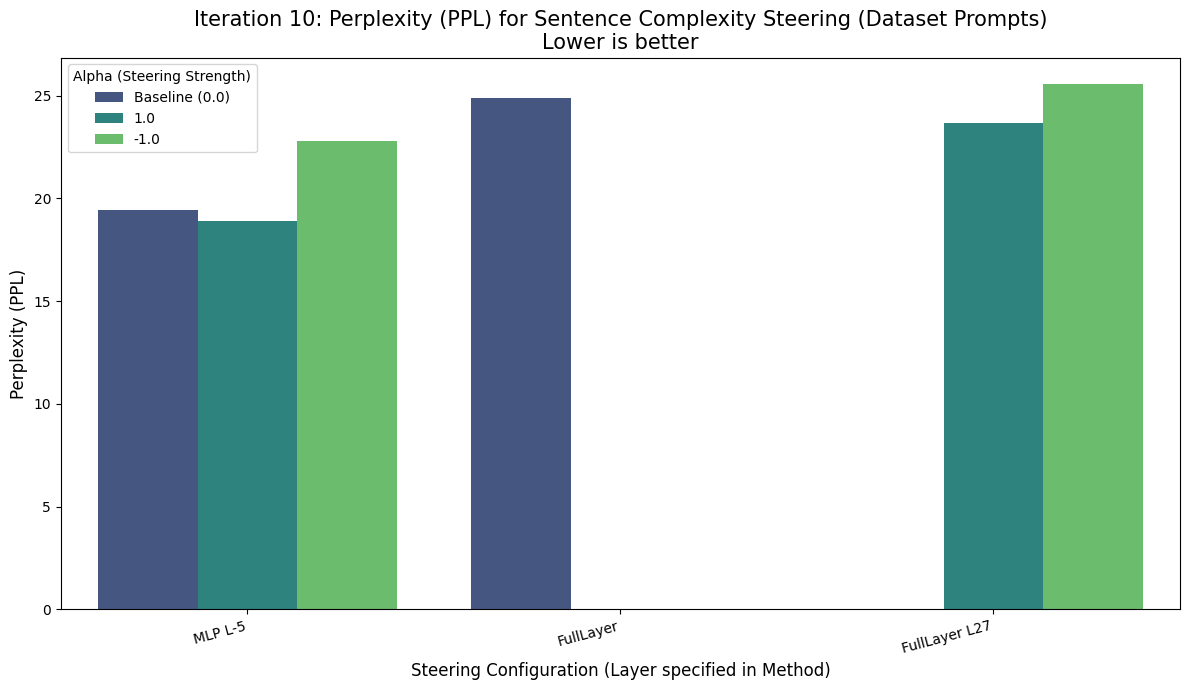

In [13]:
#Plotting PPL Results

if not metrics_df_p10.empty:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Method", y="PPL", hue="Alpha", data=metrics_df_p10, palette="viridis")
    plt.title("Iteration 10: Perplexity (PPL) for Sentence Complexity Steering (Dataset Prompts)\nLower is better", fontsize=15)
    plt.ylabel("Perplexity (PPL)", fontsize=12)
    plt.xlabel("Steering Configuration (Layer specified in Method)", fontsize=12)
    plt.xticks(rotation=15, ha="right")
    plt.legend(title="Alpha (Steering Strength)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR_P10, "P10_PPL_Comparison.png"))
    plt.show()
else:
    print("Metrics DataFrame is empty. Cannot generate PPL plot.")

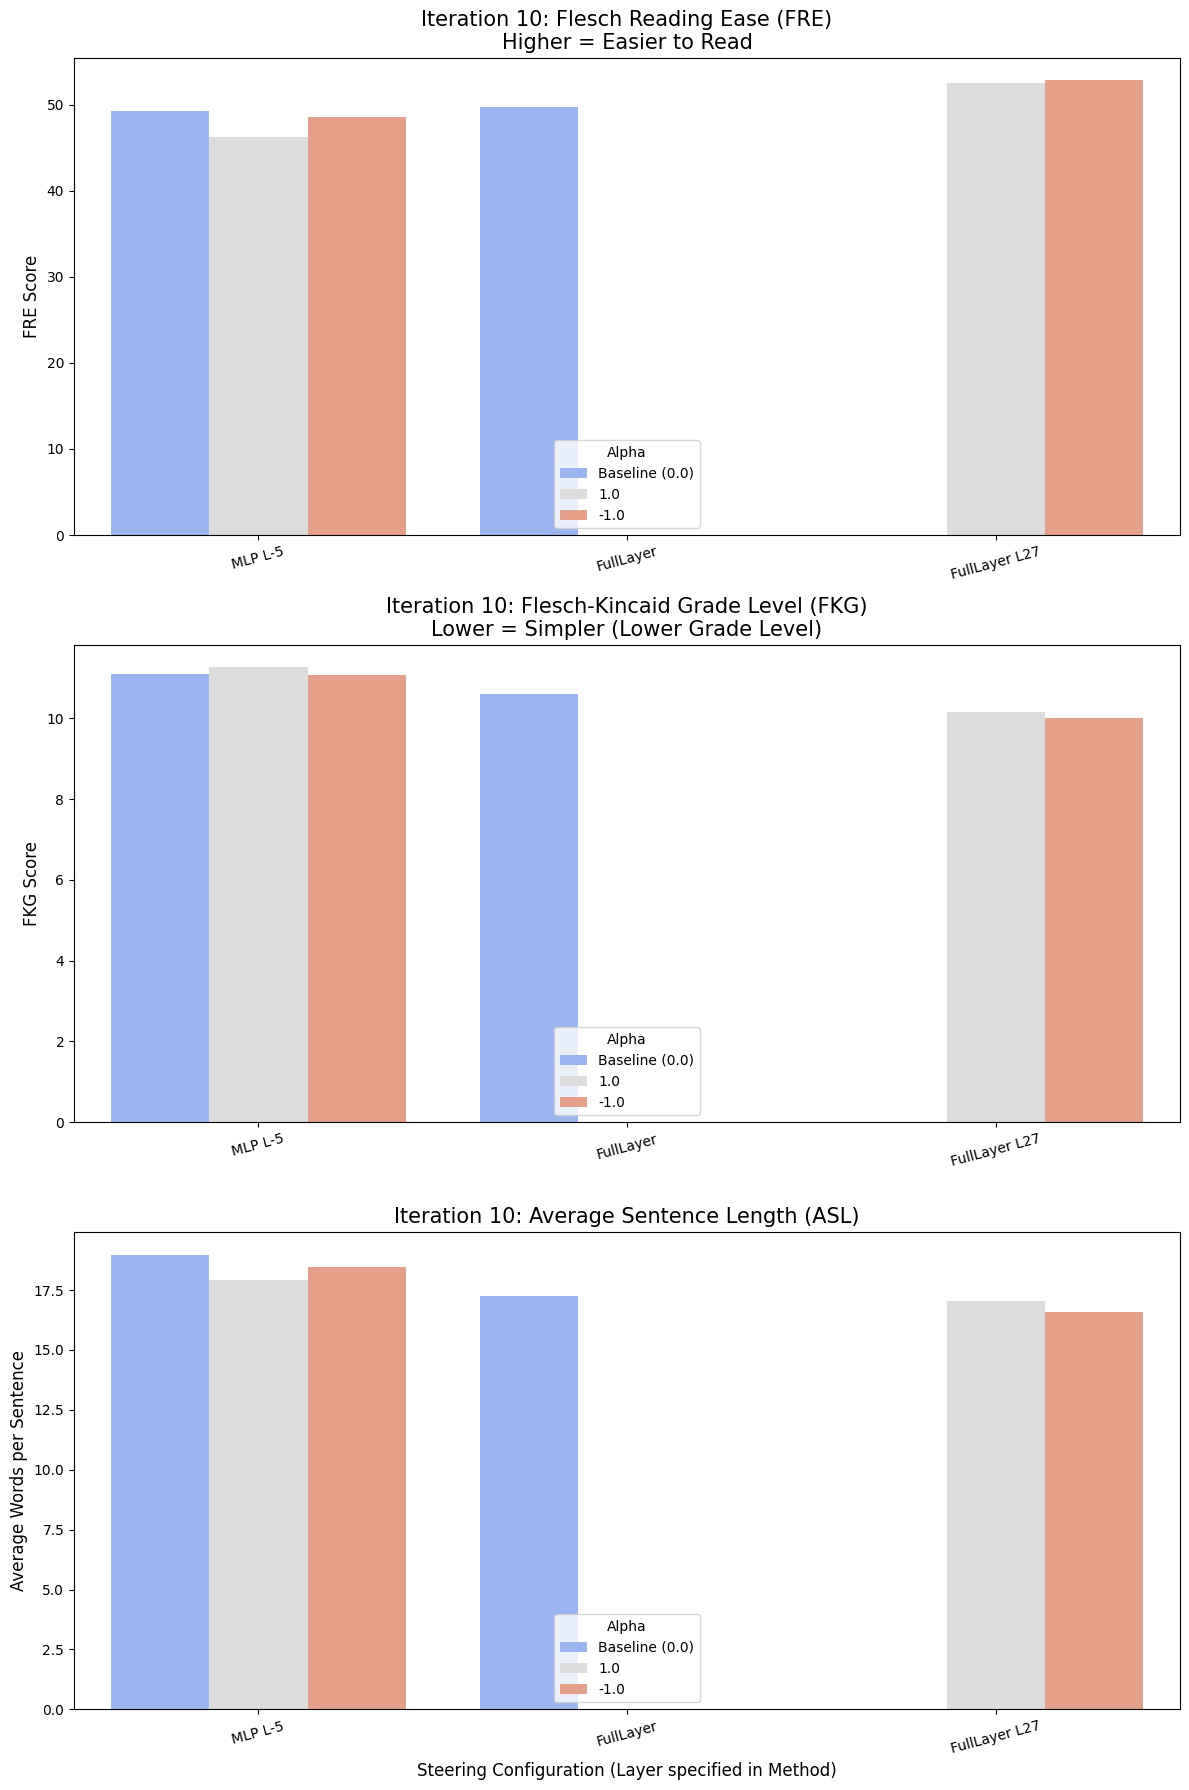

In [14]:
#Plotting Readability Scores (FRE, FKG, ASL)

if not metrics_df_p10.empty:
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    # Flesch Reading Ease (FRE) - Higher is easier
    sns.barplot(ax=axes[0], x="Method", y="FRE", hue="Alpha", data=metrics_df_p10, palette="coolwarm")
    axes[0].set_title("Iteration 10: Flesch Reading Ease (FRE)\nHigher = Easier to Read", fontsize=15)
    axes[0].set_ylabel("FRE Score", fontsize=12)
    axes[0].set_xlabel("")
    axes[0].tick_params(axis='x', rotation=15, labelsize=10)
    axes[0].legend(title="Alpha")

    # Flesch-Kincaid Grade Level (FKG) - Lower is simpler
    sns.barplot(ax=axes[1], x="Method", y="FKG", hue="Alpha", data=metrics_df_p10, palette="coolwarm")
    axes[1].set_title("Iteration 10: Flesch-Kincaid Grade Level (FKG)\nLower = Simpler (Lower Grade Level)", fontsize=15)
    axes[1].set_ylabel("FKG Score", fontsize=12)
    axes[1].set_xlabel("")
    axes[1].tick_params(axis='x', rotation=15, labelsize=10)
    axes[1].legend(title="Alpha")

    # Average Sentence Length (ASL)
    sns.barplot(ax=axes[2], x="Method", y="ASL", hue="Alpha", data=metrics_df_p10, palette="coolwarm")
    axes[2].set_title("Iteration 10: Average Sentence Length (ASL)", fontsize=15)
    axes[2].set_ylabel("Average Words per Sentence", fontsize=12)
    axes[2].set_xlabel("Steering Configuration (Layer specified in Method)", fontsize=12)
    axes[2].tick_params(axis='x', rotation=15, labelsize=10)
    axes[2].legend(title="Alpha")

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR_P10, "P10_Readability_Scores.png"))
    plt.show()
else:
    print("Metrics DataFrame is empty. Cannot generate readability plots.")

In [15]:
#Extracting Text Examples for Qualitative Analysis

print("--- Iteration 10: Example Generated Texts (First Prompt) ---")

if steering_prompts_p10_list:
    first_prompt = steering_prompts_p10_list[0]
    print(f"Prompt: \"{first_prompt}\"\n")

    # --- MLP Examples ---
    if iteration_results_p10_mlp:
        print("MLP-Steered Outputs (L-5):")
        for run_name, data in iteration_results_p10_mlp.items():
            if data['outputs']: # Check if outputs list is not empty
                # Filter out error messages if they were stored as strings
                valid_outputs = [out for out in data['outputs'] if isinstance(out, str) and not out.startswith("ERROR_") and not out.startswith("EXCEPTION_")]
                if valid_outputs:
                    print(f"  {run_name} (Alpha {data['alpha']:.2f}):")
                    print(f"    Completion: \"{valid_outputs[0][:200]}...\"\n") # Display first 200 chars of completion for first prompt
                else:
                    print(f"  {run_name} (Alpha {data['alpha']:.2f}): No valid output for the first prompt.\n")
            else:
                print(f"  {run_name} (Alpha {data['alpha']:.2f}): No outputs generated.\n")
    else:
        print("No MLP steering results available for P10 to show examples.")

    # --- Full Layer Examples ---
    if iteration_results_p10_full_layer:
        print("\nFull Layer-Steered Outputs (L27):")
        for run_name, data in iteration_results_p10_full_layer.items():
            if data['outputs']:
                valid_outputs = [out for out in data['outputs'] if isinstance(out, str) and not out.startswith("ERROR_") and not out.startswith("EXCEPTION_")]
                if valid_outputs:
                    print(f"  {run_name} (Alpha {data['alpha']:.2f}):")
                    print(f"    Completion: \"{valid_outputs[0][:200]}...\"\n")
                else:
                     print(f"  {run_name} (Alpha {data['alpha']:.2f}): No valid output for the first prompt.\n")
            else:
                print(f"  {run_name} (Alpha {data['alpha']:.2f}): No outputs generated.\n")
    else:
        print("No Full Layer steering results available for P10 to show examples.")
else:
    print("Steering prompts list is empty. Cannot show examples.")


--- Iteration 10: Example Generated Texts (First Prompt) ---
Prompt: "This coincides well with the Nara period (710 - 794)."

MLP-Steered Outputs (L-5):
  P10_MLP_ValPrompt_Baseline (Alpha 0.00):
    Completion: "Japan's history is divided into several periods, including the Jomon period, Yayoi period, Kofun period, Asuka period, Nara period, Heian period, Kamakura period, Muromachi period, Azuchi-Momoyama per..."

  P10_MLP_ValPrompt_L-5_alpha_1.00_clip_ON (Alpha 1.00):
    Completion: "Japan's history is divided into several periods, including the Jomon period, Yayoi period, Kofun period, Asuka period, Nara period, Heian period, Kamakura period, Muromachi period, Azuchi-Momoyama per..."

  P10_MLP_ValPrompt_L-5_alpha_-1.00_clip_OFF (Alpha -1.00):
    Completion: "Japan's history is divided into several periods, including the Jomon period, Yayoi period, Kofun period, Asuka period, Nara period, Heian period, Kamakura period, Muromachi period, Azuchi-Momoyama per..."


Full Layer-Steere